### Set Up

In [54]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

plt.style.use('default')

In [55]:
# Función para convertir un archivo .parquet a .csv
def convertir_parquet_a_csv(ruta_parquet, ruta_csv):
    try:
        # Leer el archivo .parquet
        datos = pd.read_parquet(ruta_parquet)
        # Guardar el DataFrame en formato .csv
        datos.to_csv(ruta_csv, index=False)
        print(f"Archivo convertido y guardado en {ruta_csv}")
    except Exception as e:
        print(f"Error al convertir el archivo: {e}")

# Ruta del archivo .parquet en Google Drive y la ruta de salida para el .csv
ruta_parquet = './data/features_cleaned.parquet'  # Cambia esta ruta según la ubicación del archivo .parquet
ruta_csv = './data/features_cleaned.csv'         # Cambia esta ruta de salida para el archivo .csv

# Llamada a la función
convertir_parquet_a_csv(ruta_parquet, ruta_csv)

Archivo convertido y guardado en ./data/features_cleaned.csv


In [56]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

# Ruta de los archivos en tu Drive
features_file = './data/features_cleaned.csv'
labels_file = './data/dfcrossmatches_prioritized_v7.0.1.csv'

# Cargar el archivo de características con 'oid' como índice
df_feat = pd.read_csv(features_file, index_col='oid')

# Cargar el archivo de etiquetas con 'oid' como índice
df_labels = pd.read_csv(labels_file, index_col='oid', on_bad_lines='skip')

# Verificar las columnas disponibles en df_labels
print("Columnas en df_labels:", df_labels.columns)

# Verificar si 'classALeRCE' existe en las columnas
if 'classALeRCE' in df_labels.columns:
    # Descartar valores infinitos en df_feat
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

    # Imprimir tamaño de la columna de clases y las primeras filas del DataFrame de características
    print(df_labels['classALeRCE'].values.size)
    print(df_feat.head())
else:
    print("La columna 'classALeRCE' no fue encontrada en df_labels.")
    print("Asegúrate de que el archivo tiene esta columna correctamente definida.")


Columnas en df_labels: Index(['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source',
       'class_source', 'separation_arcsec'],
      dtype='object')
173879
                  gal_b       gal_l  g-r_max_g_r  g-r_mean_g_r  \
oid                                                              
ZTF18aahvndq  84.778146   32.955580    -0.041541      0.246432   
ZTF19abqviuy -56.280179  109.009059    -0.079274      0.021343   
ZTF19acyogrm -24.613587  148.867482     1.280889      0.400809   
ZTF20aaiovoy  42.559095  209.082699     0.178904      0.587743   
ZTF20abcqpdj  72.178184  147.837430     0.308870      0.400827   

              g-r_max_corr_g_r  g-r_mean_corr_g_r        rb  MHPS_ratio_g  \
oid                                                                         
ZTF18aahvndq               NaN                NaN  0.882857    254.265274   
ZTF19abqviuy               NaN                NaN  0.930000     75.107750   
ZTF19acyogrm          1.227327           0.502450  0.850000     

In [57]:
df_labels.value_counts('classALeRCE')

classALeRCE
EB/EW             47541
QSO               40390
RRL               39234
LPV               15992
EA                 9961
AGN                6641
YSO                3572
SNIa               1899
RSCVn              1757
Blazar             1635
CV/Nova            1232
DSCT               1096
Periodic-Other      867
Ceph                786
NLQSO               613
SNII                389
SNIbc               139
SNIIn                51
SLSN                 35
SNIIb                21
NLAGN                13
ZZ                   10
TDE                   5
Name: count, dtype: int64

In [58]:
df_labels['classALeRCE'] = df_labels['classALeRCE'].replace(['SNIIn', 'SNIIb'], 'SNII')

# Verificar el cambio
print(df_labels['classALeRCE'].value_counts())

classALeRCE
EB/EW             47541
QSO               40390
RRL               39234
LPV               15992
EA                 9961
AGN                6641
YSO                3572
SNIa               1899
RSCVn              1757
Blazar             1635
CV/Nova            1232
DSCT               1096
Periodic-Other      867
Ceph                786
NLQSO               613
SNII                461
SNIbc               139
SLSN                 35
NLAGN                13
ZZ                   10
TDE                   5
Name: count, dtype: int64


In [59]:
#defining taxonomy tree according to the taxonomy presented in Section 2.2 of the paper.
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(113193,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [60]:
# Definir las columnas que deben ser excluidas de la tabla df_nd
rm_nd_cols = [
    'n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
    'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2',
    'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2',
    'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2',
    'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1',
    'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2'
]

# Verificar qué columnas de rm_nd_cols no están en df_feat
missing_cols = [col for col in rm_nd_cols if col not in df_feat.columns]

if missing_cols:
    print(f"Las siguientes columnas no se encuentran en df_feat y serán ignoradas: {missing_cols}")

# Eliminar solo las columnas que están presentes
cols_to_drop = [col for col in rm_nd_cols if col in df_feat.columns]

# Unir el DataFrame labels con las características restantes, excluyendo las columnas definidas
df = labels.join(df_feat.drop(cols_to_drop, axis=1), how='inner')

# Reemplazar valores infinitos por NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Copiar DataFrame para entrenamiento y rellenar NaN con -999
df_train = df.copy()
df_train = df_train.fillna(-999)

# Extraer las etiquetas
labels = df[['class_original', 'class_hierachical']]

# Verificar si 'Mean_1', 'Mean_2', 'class_original' y 'class_hierachical' están presentes antes de eliminarlas
cols_to_remove = ['Mean_1', 'Mean_2', 'class_original', 'class_hierachical']
cols_to_remove = [col for col in cols_to_remove if col in df.columns]

# Eliminar las columnas existentes
df.drop(cols_to_remove, axis=1, inplace=True)

# Rellenar los NaN restantes con -999
df = df.fillna(-999)

# Imprimir el número de valores en class_original
print(len(labels['class_original'].values))

# Mostrar las primeras filas del DataFrame final
df.head()


Las siguientes columnas no se encuentran en df_feat y serán ignoradas: ['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2']
1823


,gal_b,gal_l,g-r_max_g_r,g-r_mean_g_r,g-r_max_corr_g_r,g-r_mean_corr_g_r,rb,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,...,GP_DRW_tau_g,GP_DRW_sigma_r,GP_DRW_tau_r,sgscore1,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aarphwc,28.433587,77.811324,-0.080040,-0.030871,-999.000000,-999.000000,0.900000,926.190308,7.336081,0.007921,...,160.036277,0.236910,121.588791,0.761167,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18acenqto,-38.019501,218.826426,-0.032061,0.117119,-0.037329,-0.406273,0.930000,48.875584,0.277011,0.005668,...,1191.222125,2.360263,1018.152344,0.015167,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18abshezu,-72.966494,72.632636,0.096467,-0.129673,0.098831,-0.108766,0.758333,1358.509155,6.566469,0.004834,...,86.349313,0.243571,71.909902,0.004792,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF19aanesgt,33.430310,150.468865,0.153276,0.080107,-999.000000,-999.000000,0.740000,105.981819,0.279318,0.002636,...,10.120767,0.066081,7.167300,0.907768,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18acyxnyw,60.433207,129.525097,-0.034018,0.247023,0.017709,0.253078,0.764286,181.867783,1.505945,0.008280,...,123.039151,0.115851,56.375442,0.019583,0.791,4.484,2.035118,6.519118,1.78204,6.26604


In [61]:
#which are the features included in the model?
print(np.array(df.columns))
print(len(np.array(df.columns)))

['gal_b' 'gal_l' 'g-r_max_g_r' 'g-r_mean_g_r' 'g-r_max_corr_g_r'
 'g-r_mean_corr_g_r' 'rb' 'MHPS_ratio_g' 'MHPS_low_g' 'MHPS_high_g'
 'MHPS_non_zero_g' 'MHPS_PN_flag_g' 'MHPS_ratio_r' 'MHPS_low_r'
 'MHPS_high_r' 'MHPS_non_zero_r' 'MHPS_PN_flag_r' 'iqr_g' 'iqr_r'
 'Amplitude_g' 'AndersonDarling_g' 'Autocor_length_g' 'Beyond1Std_g'
 'Con_g' 'Eta_e_g' 'Gskew_g' 'MaxSlope_g' 'Mean_g' 'Meanvariance_g'
 'MedianAbsDev_g' 'MedianBRP_g' 'PairSlopeTrend_g' 'PercentAmplitude_g'
 'Q31_g' 'Rcs_g' 'Skew_g' 'SmallKurtosis_g' 'Std_g' 'StetsonK_g' 'Pvar_g'
 'ExcessVar_g' 'SF_ML_amplitude_g' 'SF_ML_gamma_g' 'IAR_phi_g'
 'LinearTrend_g' 'Amplitude_r' 'AndersonDarling_r' 'Autocor_length_r'
 'Beyond1Std_r' 'Con_r' 'Eta_e_r' 'Gskew_r' 'MaxSlope_r' 'Mean_r'
 'Meanvariance_r' 'MedianAbsDev_r' 'MedianBRP_r' 'PairSlopeTrend_r'
 'PercentAmplitude_r' 'Q31_r' 'Rcs_r' 'Skew_r' 'SmallKurtosis_r' 'Std_r'
 'StetsonK_r' 'Pvar_r' 'ExcessVar_r' 'SF_ML_amplitude_r' 'SF_ML_gamma_r'
 'IAR_phi_r' 'LinearTrend_r' 'delta_mag_f

In [62]:
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1364
SNIbc 96
SNII 339
SLSN 24
QSO 0
AGN 0
Blazar 0
YSO 0
CV/Nova 0
LPV 0
E 0
DSCT 0
RRL 0
CEP 0
Periodic-Other 0


Counter({'SNIa': 1364, 'SNII': 339, 'SNIbc': 96, 'SLSN': 24})
       number
SNIa     1364
SNII      339
SNIbc      96
SLSN       24


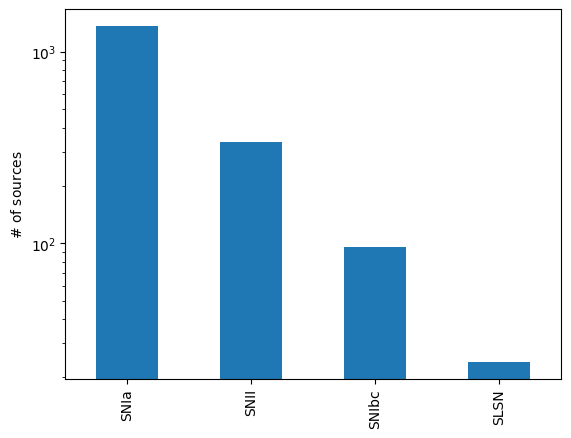

In [63]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')

plt.ylabel(r'$\#$ of sources')

plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

In [64]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()



def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### RF

In [65]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

1823
1823
0 0 1458


In [66]:
import os
import numpy as np

# Crear la carpeta si no existe
os.makedirs('final_BHRF_model', exist_ok=True)

# Guardar los índices
np.save('final_BHRF_model/labels_training_sample.npy', X_train_hierarchical.index.values)
np.save('final_BHRF_model/labels_testint_sample.npy', X_test_hierarchical.index.values)

In [67]:
model_transient_layer = './models/rf_model_transient.pkl'  # Nombre del archivo para el modelo
features_pickle = './models/features_transient.pkl'  # Nombre del archivo para las características

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

with open(features_pickle, 'wb') as f:
            pickle.dump(
                features_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.



['SLSN' 'SNII' 'SNIa' 'SNIbc']


#### RF: confusion_matrix

SPM_t0_g & 0.027
SPM_tau_rise_r & 0.026
delta_mjd_fid_r & 0.024
SPM_gamma_r & 0.023
SPM_tau_rise_g & 0.020
LinearTrend_r & 0.019
MHPS_ratio_g & 0.019
g-r_max_g_r & 0.018
delta_mjd_fid_g & 0.017
SPM_t0_r & 0.016
SPM_gamma_g & 0.015
MHPS_high_g & 0.014
dmag_first_det_fid_g & 0.013
first_mag_r & 0.013
SPM_tau_fall_r & 0.012
AndersonDarling_r & 0.012
g-r_mean_g_r & 0.011
Period_band_g & 0.011
Period_band_r & 0.010
SPM_tau_fall_g & 0.010
dmag_non_det_fid_r & 0.010
Power_rate_2_g_r & 0.009
dmag_first_det_fid_r & 0.009
Power_rate_3_g_r & 0.009
MHPS_ratio_r & 0.009
SPM_beta_g & 0.009
IAR_phi_g & 0.008
IAR_phi_r & 0.008
Power_rate_4_g_r & 0.008
MHPS_high_r & 0.008


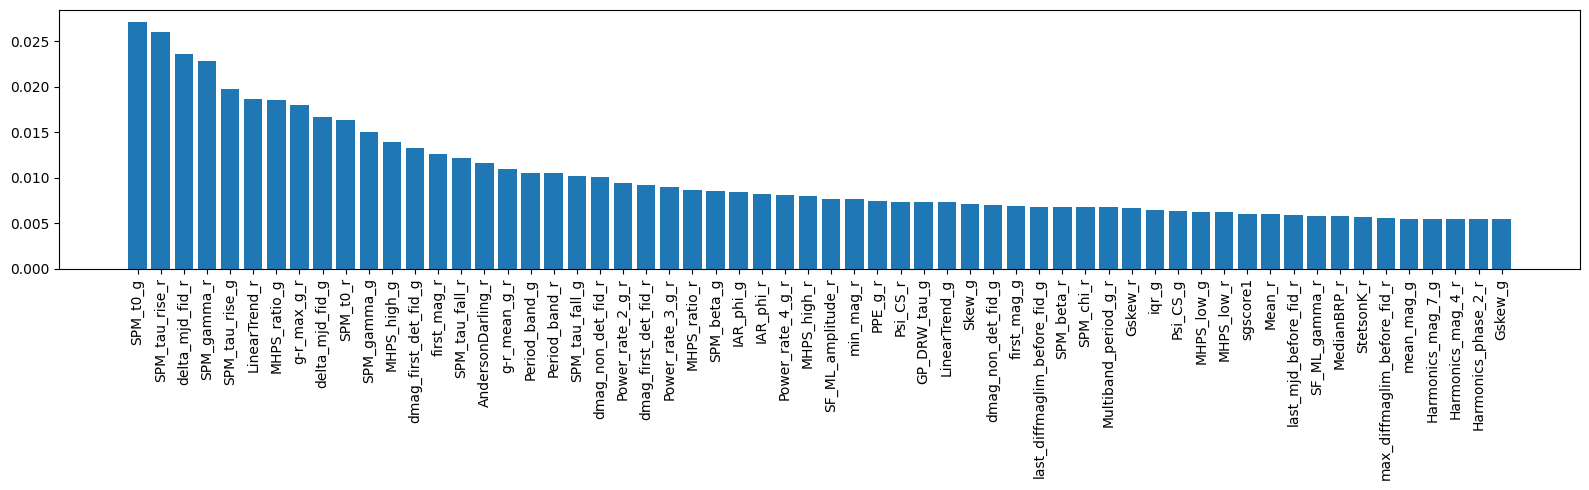

In [68]:
plot_feature_importances(rf_model_transient, features_transient, 'final_BHRF_model/feature_ranking_transient_level.pdf')

In [69]:
# Clases de interés
selected_classes = ['SLSN', 'SNII', 'SNIa', 'SNIbc']

# Filtrar las etiquetas verdaderas y predicciones para estas clases
mask = y_true_transient.isin(selected_classes)
y_true_selected = y_true_transient[mask]
y_pred_selected = y_pred_transient[mask]

Accuracy: 0.68
Balanced accuracy: 0.52
Macro precision: 0.45
Macro recall: 0.52
Macro F1: 0.43
              precision    recall  f1-score   support

        SLSN       0.10      0.40      0.16         5
        SNII       0.65      0.47      0.55        68
        SNIa       0.90      0.75      0.82       273
       SNIbc       0.13      0.47      0.20        19

    accuracy                           0.68       365
   macro avg       0.45      0.52      0.43       365
weighted avg       0.80      0.68      0.73       365

Matriz de confusión normalizada


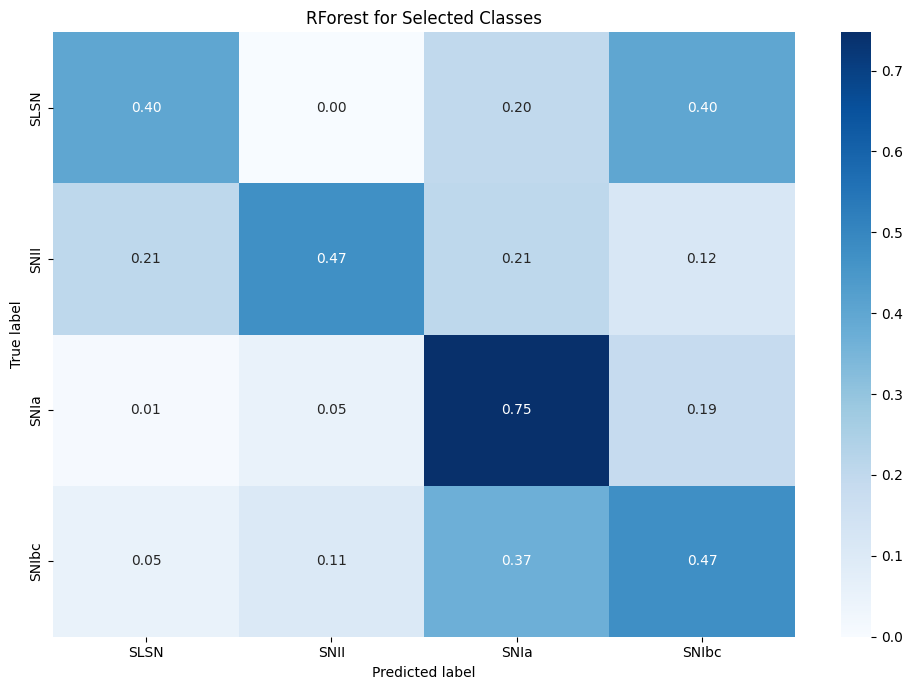

In [70]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular las métricas globales
accuracy = accuracy_score(y_true_selected, y_pred_selected)
balanced_accuracy = balanced_accuracy_score(y_true_selected, y_pred_selected)
macro_precision = precision_score(y_true_selected, y_pred_selected, average='macro')
macro_recall = recall_score(y_true_selected, y_pred_selected, average='macro')
macro_f1 = f1_score(y_true_selected, y_pred_selected, average='macro')

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
report = classification_report(y_true_selected, y_pred_selected, target_names=selected_classes)
print(report)

# Matriz de confusión y otras visualizaciones
cm_selected = confusion_matrix(y_true_selected, y_pred_selected, labels=selected_classes)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='rf_confusion_matrix.pdf', normalize=True, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()
    
plot_confusion_matrix(cm_selected, classes=selected_classes, plot_name='rf_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='RForest for Selected Classes')


Matriz de confusión normalizada


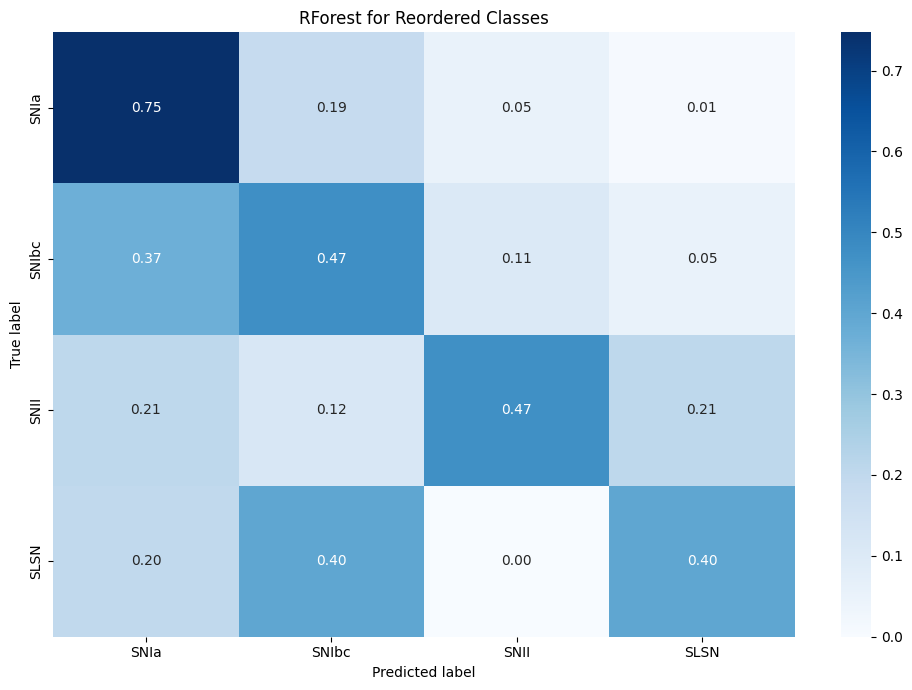

In [71]:
cm_selected = confusion_matrix(y_true_selected, y_pred_selected, labels=['SNIa', 'SNIbc', 'SNII', 'SLSN'])

# Recalcular la matriz de confusión con el nuevo orden
plot_confusion_matrix(cm_selected, classes=['SNIa', 'SNIbc', 'SNII', 'SLSN'], plot_name='rf_confusion_matrix_selected_classes_reordered.pdf',
                      normalize=True, title='RForest for Reordered Classes')

### Small MLP 1

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

# y_train_transient y y_test_original son categóricos
label_encoder = LabelEncoder() # se consificarán a numéricos
y_train_encoded = label_encoder.fit_transform(y_train_transient)
y_test_encoded = label_encoder.transform(y_test_original)

# Convertir las etiquetas a tensores para PyTorch
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Escalando los datos de entrada N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transient)
X_test_scaled = scaler.transform(X_test_transient)

# Convertir los datos de entrada escalados a tensores para PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

Ahora etiquetas y vectores de entrada son tensores PyTorch ↑↑↑

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

# y_train_transient y y_test_original son categóricos
label_encoder = LabelEncoder()  # Convertir a numéricos
y_train_encoded = label_encoder.fit_transform(y_train_transient)
y_test_encoded = label_encoder.transform(y_test_original)

# Escalando los datos de entrada N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transient)
X_test_scaled = scaler.transform(X_test_transient)

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)

# Convertir los datos de entrada escalados a tensores para PyTorch
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convertir las etiquetas a tensores para PyTorch
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [74]:
# Definir la clase del modelo MLP
class MLPModel(nn.Module):  # Modelo en PyTorch
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 100)  # Primera capa densa (lineal)
        # Produce 100 neuronas como salida
        self.fc2 = nn.Linear(100, 50)  # Produce 50 neuronas como salida
        self.fc3 = nn.Linear(50, len(torch.unique(y_train_tensor)))  # Produce una salida del 
        # tamaño igual al número de clases en las etiquetas

    def forward(self, x):  # Se introducen no linealidades
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No tiene activación
        return x

# Inicializar el modelo
model = MLPModel()

# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # En un problema de clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Optimizador Adam con tasa de aprendizaje de 0.0001

In [75]:
# Bucle de entrenamiento
num_epochs = 220
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Imprimir las pérdidas finales
print(f"Entrenamiento finalizado. Pérdida de entrenamiento: {train_losses[-1]:.4f}, Pérdida de validación: {val_losses[-1]:.4f}")

Epoch [10/220], Loss: 1.3857, Val Loss: 1.4178
Epoch [20/220], Loss: 1.3710, Val Loss: 1.3992
Epoch [30/220], Loss: 1.3577, Val Loss: 1.3814
Epoch [40/220], Loss: 1.3442, Val Loss: 1.3623
Epoch [50/220], Loss: 1.3297, Val Loss: 1.3414
Epoch [60/220], Loss: 1.3144, Val Loss: 1.3214
Epoch [70/220], Loss: 1.2984, Val Loss: 1.3044
Epoch [80/220], Loss: 1.2818, Val Loss: 1.2901
Epoch [90/220], Loss: 1.2642, Val Loss: 1.2780
Epoch [100/220], Loss: 1.2456, Val Loss: 1.2675
Epoch [110/220], Loss: 1.2263, Val Loss: 1.2570
Epoch [120/220], Loss: 1.2065, Val Loss: 1.2464
Epoch [130/220], Loss: 1.1866, Val Loss: 1.2361
Epoch [140/220], Loss: 1.1664, Val Loss: 1.2272
Epoch [150/220], Loss: 1.1457, Val Loss: 1.2196
Epoch [160/220], Loss: 1.1244, Val Loss: 1.2119
Epoch [170/220], Loss: 1.1028, Val Loss: 1.2038
Epoch [180/220], Loss: 1.0809, Val Loss: 1.1977
Epoch [190/220], Loss: 1.0590, Val Loss: 1.1927
Epoch [200/220], Loss: 1.0377, Val Loss: 1.1868
Epoch [210/220], Loss: 1.0170, Val Loss: 1.1811
E

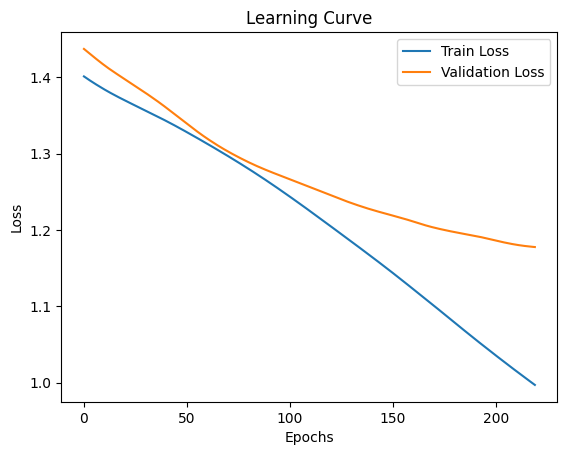

In [76]:
# Graficar la curva de aprendizaje
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Accuracy: 0.50
Balanced accuracy: 0.28
Macro precision: 0.30
Macro recall: 0.28
Macro F1: 0.27
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         5
        SNII       0.29      0.31      0.30        68
        SNIa       0.84      0.58      0.69       273
       SNIbc       0.06      0.21      0.09        19

    accuracy                           0.50       365
   macro avg       0.30      0.28      0.27       365
weighted avg       0.69      0.50      0.58       365

Matriz de confusión normalizada


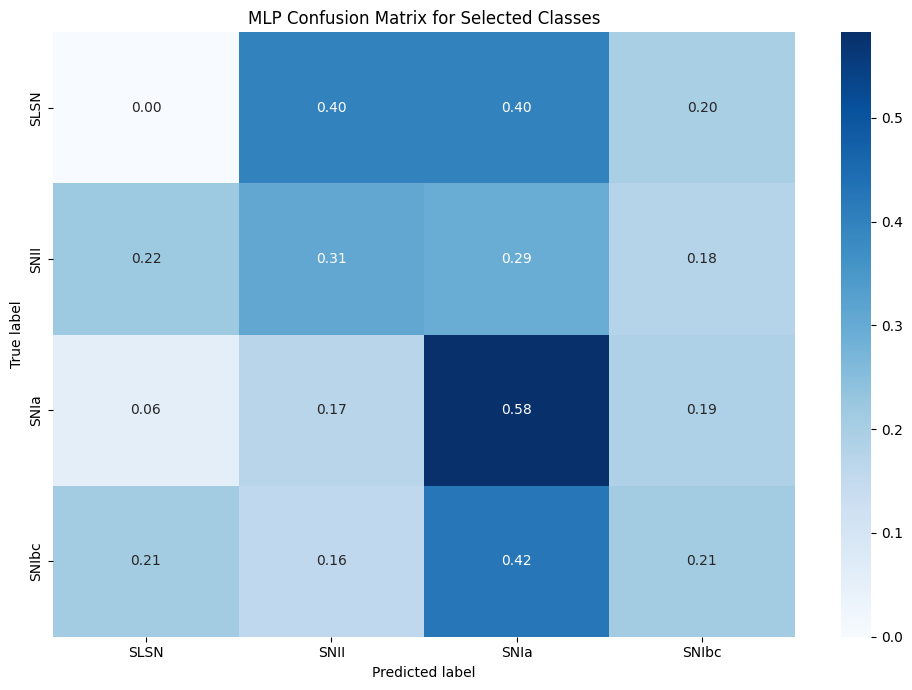

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Realizar predicciones sobre el conjunto de prueba
model.eval()  # Colocar el modelo en modo evaluación
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Obtener las predicciones
    _, y_pred_tensor = torch.max(test_outputs, 1)  # Convertir probabilidades en clases

# Convertir los tensores a numpy arrays para las métricas de sklearn
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Calcular las métricas globales
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
selected_classes = label_encoder.classes_  # Obtener los nombres de las clases originales
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='mlp_confusion_matrix.pdf', normalize=True, title='MLP Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='mlp_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='MLP Confusion Matrix for Selected Classes')


#### MLP: Exportar

In [78]:
# Guardar el modelo en formato .pth
model_path = './models/mlp_model_transient.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: ./models/mlp_model_transient.pth


In [79]:
# Guardar los parámetros entrenados en trained_parameters.pth
torch.save(model.state_dict(), './models/trained_parameters.pth')
print('Parámetros entrenados guardados en: trained_parameters.pth')

Parámetros entrenados guardados en: trained_parameters.pth


### MLP1

Epoch 1/70, Train Loss: 1.3427, Val Loss: 1.2829
Epoch 2/70, Train Loss: 1.2682, Val Loss: 1.1898
Epoch 3/70, Train Loss: 1.1700, Val Loss: 1.0823
Epoch 4/70, Train Loss: 1.0916, Val Loss: 0.9941
Epoch 5/70, Train Loss: 1.0181, Val Loss: 0.9205
Epoch 6/70, Train Loss: 0.9726, Val Loss: 0.8713
Epoch 7/70, Train Loss: 0.9237, Val Loss: 0.8325
Epoch 8/70, Train Loss: 0.8879, Val Loss: 0.8017
Epoch 9/70, Train Loss: 0.8623, Val Loss: 0.7751
Epoch 10/70, Train Loss: 0.8393, Val Loss: 0.7532
Epoch 11/70, Train Loss: 0.8112, Val Loss: 0.7372
Epoch 12/70, Train Loss: 0.7941, Val Loss: 0.7212
Epoch 13/70, Train Loss: 0.7676, Val Loss: 0.7017
Epoch 14/70, Train Loss: 0.7513, Val Loss: 0.6831
Epoch 15/70, Train Loss: 0.7394, Val Loss: 0.6734
Epoch 16/70, Train Loss: 0.7199, Val Loss: 0.6576
Epoch 17/70, Train Loss: 0.7128, Val Loss: 0.6440
Epoch 18/70, Train Loss: 0.7017, Val Loss: 0.6304
Epoch 19/70, Train Loss: 0.6921, Val Loss: 0.6201
Epoch 20/70, Train Loss: 0.6667, Val Loss: 0.6121
Epoch 21/

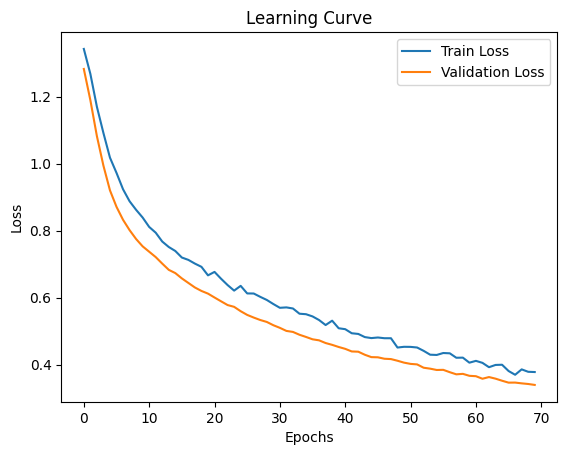

Accuracy: 0.68
Balanced accuracy: 0.42
Macro precision: 0.38
Macro recall: 0.42
Macro F1: 0.38
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         5
        SNII       0.52      0.63      0.57        68
        SNIa       0.88      0.73      0.80       273
       SNIbc       0.12      0.32      0.17        19

    accuracy                           0.68       365
   macro avg       0.38      0.42      0.38       365
weighted avg       0.76      0.68      0.71       365

Matriz de confusión normalizada


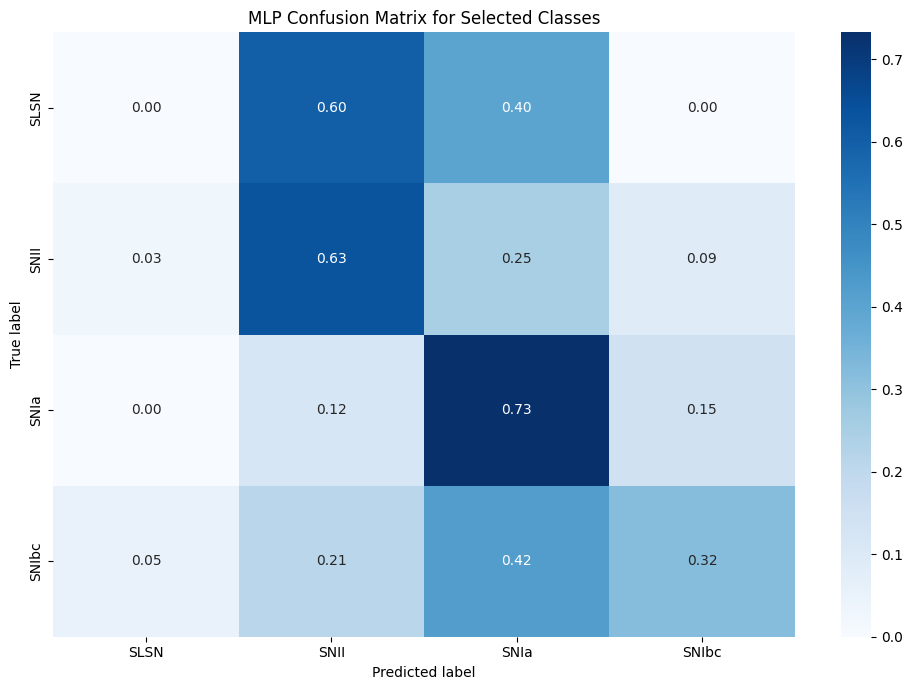

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

# Calcula los pesos de las clases basados en las etiquetas resampleadas
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)

# Convertir los pesos de clase a tensor de PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32) # Asegúrate de que esté en el dispositivo correcto

# Definir la función de pérdida con los pesos de clase y el optimizador
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Entropía cruzada con pesos de clase
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Supongo que ya tienes los datos X_train_transient, X_test_transient, y_train_transient, y_test_original
#MLP 1
# 1. Codificación de etiquetas categóricas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_transient)
y_test_encoded = label_encoder.transform(y_test_original)

# 2. Escalado de los datos de entrada N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transient)
X_test_scaled = scaler.transform(X_test_transient)

# 3. Aplicar SMOTE a los datos de entrenamiento (manejo del desbalance)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)

# 4. Convertir los datos de entrada escalados a tensores para PyTorch
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 5. Convertir las etiquetas a tensores para PyTorch
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
# Convertir los datos de entrada escalados y las etiquetas a tensores (ya en tu código)

# Crear datasets a partir de los tensores
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Dividir los datos de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Crear DataLoaders para manejar los lotes de datos
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Definir el dispositivo (CPU o GPU)

# 6. Definir el modelo MLP con dos capas ocultas y dropout
class MLP1Model(nn.Module):
    def __init__(self):
        super(MLP1Model, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 256)  # Primera capa con 256 neuronas
        self.fc2 = nn.Linear(256, 128)  # Segunda capa con 128 neuronas
        self.fc3 = nn.Linear(128, len(torch.unique(y_train_tensor)))  # Capa de salida para clasificación multiclase
        self.dropout = nn.Dropout(0.5)  # Dropout para regularización

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activación ReLU para la primera capa
        x = self.dropout(x)  # Dropout después de la primera capa
        x = torch.relu(self.fc2(x))  # Activación ReLU para la segunda capa
        x = self.dropout(x)  # Dropout después de la segunda capa
        x = self.fc3(x)  # Capa de salida
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Definir el dispositivo

# 7. Inicializar el modelo MLP
model = MLP1Model().to(device)

# Ya en la parte 8 del código, justo después de calcular los pesos de clase
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Asegúrate de que los pesos estén en el mismo dispositivo que el modelo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)  # Mover los pesos al dispositivo correcto

# 9. Definir la función de pérdida con los pesos de clase y el optimizador
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Entropía cruzada con pesos de clase
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Optimizador Adam con tasa de aprendizaje baja

# 10. Bucle de entrenamiento
# Definir el bucle de entrenamiento usando DataLoader
def train_model_with_loader(model, optimizer, criterion, train_loader, val_loader, epochs=70):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Bucle de entrenamiento por lotes
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Mover al dispositivo correcto
            optimizer.zero_grad()

            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Bucle de validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)  # Mover al dispositivo correcto
                val_outputs = model(X_val_batch)
                val_loss += criterion(val_outputs, y_val_batch).item()

        val_losses.append(val_loss / len(val_loader))  # Mover fuera del bucle de validación

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Graficar la curva de aprendizaje
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()



# Llamar a la función de entrenamiento con los DataLoaders
train_model_with_loader(model, optimizer, criterion, train_loader, val_loader, epochs=70)
# Colocar el tensor de prueba en el mismo dispositivo que el modelo
X_test_tensor = X_test_tensor.to(device)

# 12. Evaluación del modelo y matriz de confusión
model.eval()  # Colocar el modelo en modo evaluación
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Obtener las predicciones
    _, y_pred_tensor = torch.max(test_outputs, 1)  # Convertir probabilidades en clases



# Convertir los tensores a numpy arrays para las métricas de sklearn
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Calcular las métricas globales
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
selected_classes = label_encoder.classes_  # Obtener los nombres de las clases originales
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='mlp_confusion_matrix.pdf', normalize=True, title='MLP Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='mlp_confusion_matrix_selected_classes.pdf', normalize=True, title='MLP Confusion Matrix for Selected Classes')

### MLP2 for Multi Class SVDD

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

# y_train_transient y y_test_original son categóricos
label_encoder = LabelEncoder()  # Convertir a numéricos
y_train_encoded = label_encoder.fit_transform(y_train_transient)
y_test_encoded = label_encoder.transform(y_test_original)

# Escalando los datos de entrada N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transient)
X_test_scaled = scaler.transform(X_test_transient)

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)

# Convertir los datos de entrada escalados a tensores para PyTorch
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convertir las etiquetas a tensores para PyTorch
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Supongo que el número de clases es el mismo que en tu MLPModel, es decir, len(torch.unique(y_train_tensor))

class classvdd(nn.Module):
    """Pytorch implementation of an autoencoder based on MLP."""

    def __init__(self, input_dim, z_dim, num_classes):
        super(classvdd, self).__init__()
        # Encoder Architecture
        self.enc1 = nn.Linear(input_dim, 512)
        self.encbn1 = nn.BatchNorm1d(512)
        self.enc2 = nn.Linear(512, 256)
        self.encbn2 = nn.BatchNorm1d(256)
        self.enc3 = nn.Linear(256, 128)
        self.encbn3 = nn.BatchNorm1d(128)
        self.enc4 = nn.Linear(128, z_dim, bias=False)
        self.fc_out = nn.Linear(z_dim, num_classes)  # Capa de salida para clasificación

    def encode(self, x):
        h = F.leaky_relu(self.encbn1(self.enc1(x)))
        h = F.leaky_relu(self.encbn2(self.enc2(h)))
        h = F.leaky_relu(self.encbn3(self.enc3(h)))
        return self.enc4(h)
    
    def forward(self, x):
        """Forward pass"""
        z = self.encode(x)
        out = self.fc_out(z)  # Usar salida de clasificación
        return out

    def compute_loss(self, outputs, labels):
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = criterion(outputs, labels)
        return loss

# Definir el número de características de entrada (dimensiones) y latente (z_dim)
input_dim = X_train_scaled.shape[1]  # Número de características de entrada
z_dim = 64  # Puedes ajustar este valor según sea necesario
num_classes = len(torch.unique(y_train_tensor))  # Número de clases

# Inicializar el modelo
model = classvdd(input_dim=input_dim, z_dim=z_dim, num_classes=num_classes)

# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # En un problema de clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)  # Optimizador Adam con tasa de aprendizaje de 0.0001

# Definir el optimizador
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Bucle de entrenamiento
num_epochs = 150
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = model.compute_loss(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    
    # Imprimir cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Evaluar el modelo con precisión
with torch.no_grad():
    y_pred = torch.argmax(model(X_test_tensor), dim=1)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')


Epoch [10/150], Loss: 1.1754, Val Loss: 1.3394
Epoch [20/150], Loss: 1.0328, Val Loss: 1.2572
Epoch [30/150], Loss: 0.9178, Val Loss: 1.1555
Epoch [40/150], Loss: 0.8160, Val Loss: 1.0592
Epoch [50/150], Loss: 0.7219, Val Loss: 0.9844
Epoch [60/150], Loss: 0.6343, Val Loss: 0.9200
Epoch [70/150], Loss: 0.5517, Val Loss: 0.8726
Epoch [80/150], Loss: 0.4729, Val Loss: 0.8357
Epoch [90/150], Loss: 0.3988, Val Loss: 0.8019
Epoch [100/150], Loss: 0.3327, Val Loss: 0.7730
Epoch [110/150], Loss: 0.2752, Val Loss: 0.7490
Epoch [120/150], Loss: 0.2269, Val Loss: 0.7215
Epoch [130/150], Loss: 0.1868, Val Loss: 0.6961
Epoch [140/150], Loss: 0.1542, Val Loss: 0.6888
Epoch [150/150], Loss: 0.1276, Val Loss: 0.6933
Precisión en el conjunto de prueba: 0.7370


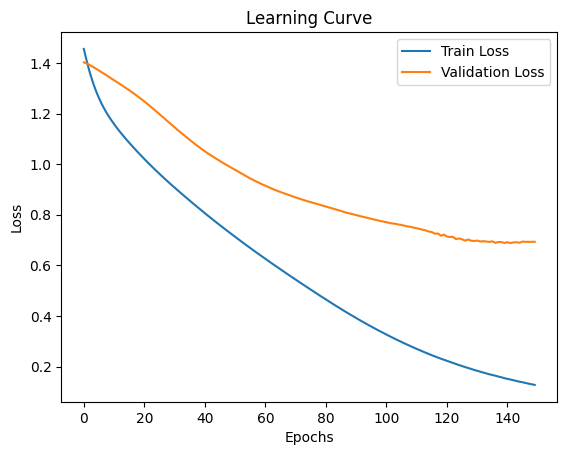

In [83]:
# Graficar la curva de aprendizaje
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Accuracy: 0.74
Balanced accuracy: 0.39
Macro precision: 0.38
Macro recall: 0.39
Macro F1: 0.39
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         5
        SNII       0.49      0.51      0.50        68
        SNIa       0.86      0.84      0.85       273
       SNIbc       0.17      0.21      0.19        19

    accuracy                           0.74       365
   macro avg       0.38      0.39      0.39       365
weighted avg       0.74      0.74      0.74       365

Matriz de confusión normalizada


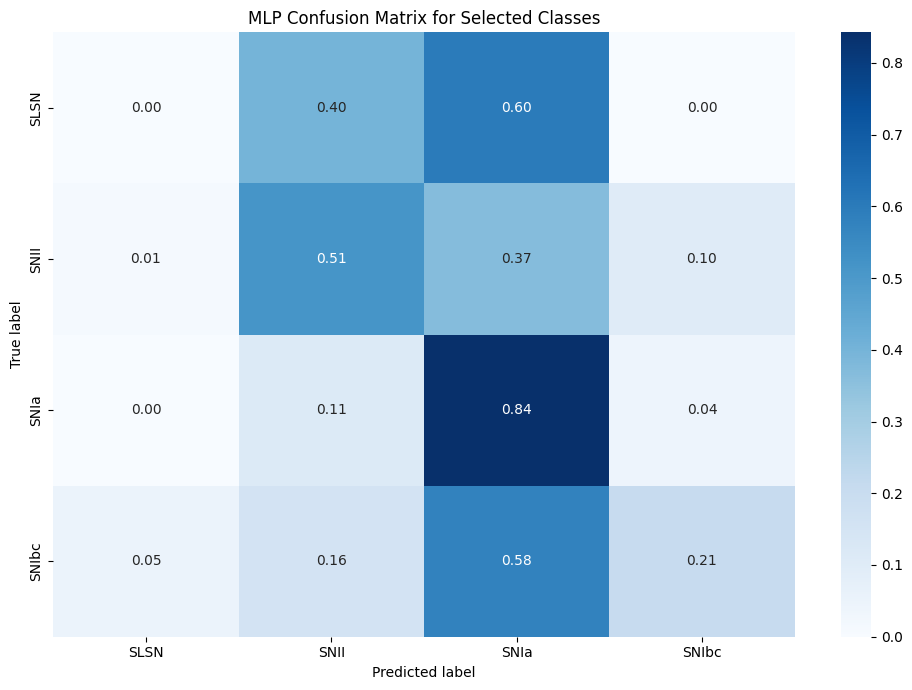

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Realizar predicciones sobre el conjunto de prueba
model.eval()  # Colocar el modelo en modo evaluación
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Obtener las predicciones
    _, y_pred_tensor = torch.max(test_outputs, 1)  # Convertir probabilidades en clases

# Convertir los tensores a numpy arrays para las métricas de sklearn
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Calcular las métricas globales
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
selected_classes = label_encoder.classes_  # Obtener los nombres de las clases originales
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='mlp_confusion_matrix.pdf', normalize=True, title='MLP Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='mlp_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='MLP Confusion Matrix for Selected Classes')


#### MLP: Exportar

In [85]:
# Después de finalizar el entrenamiento

# Guardar el modelo en formato .pth
model_path = './models/SVDDmlp.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: ./models/SVDDmlp.pth


# Clasificación

### Clasificación MLP

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



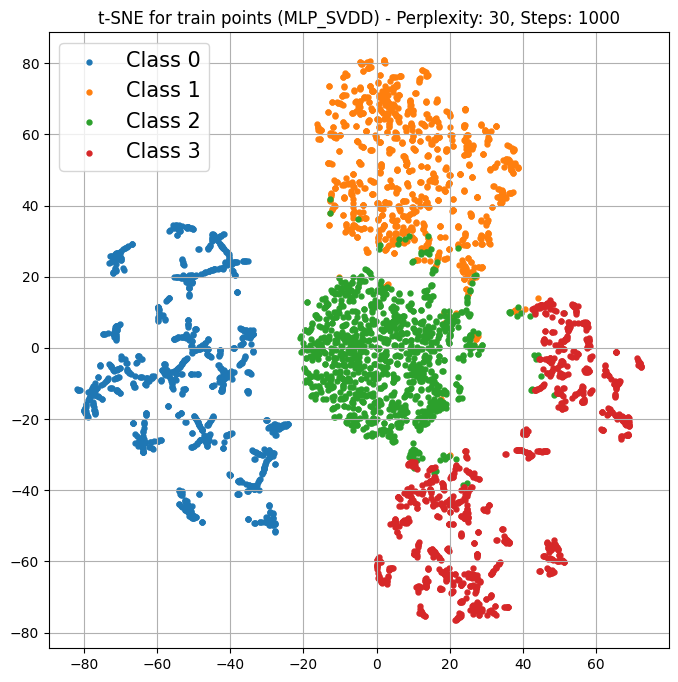

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = classvdd(input_dim=input_dim, z_dim=z_dim, num_classes=num_classes)

# Cargar el modelo entrenado
model.load_state_dict(torch.load('./models/SVDDmlp.pth'))
model.eval()  # Colocar el modelo en modo de evaluación

# Extraer el espacio latente directamente de los tensores de entrenamiento
with torch.no_grad():
    latents_train = model.encode(X_train_tensor)  # Extraer el espacio latente directamente del modelo
    labels_train = y_train_tensor  # Usar las etiquetas correspondientes a X_train_tensor

# Convertir tensores a numpy para t-SNE
latents_train_np = latents_train.numpy()
labels_train_np = labels_train.numpy()

# Ajustar perplejidad y número de iteraciones (steps)
perplexity = 30  # Ajusta este valor según el tamaño del dataset (valores típicos: 5 a 50)
n_iter = 1000  # Número de iteraciones (steps), puedes ajustarlo (valores típicos: 250 a 1000)

# Aplicar t-SNE con los nuevos parámetros
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
latents_2d = tsne.fit_transform(latents_train_np)

# Visualización de los puntos t-SNE
plt.figure(figsize=(8, 8))
plt.title(f't-SNE for train points (MLP_SVDD) - Perplexity: {perplexity}, Steps: {n_iter}')

# Colores para cada clase
for key in range(len(np.unique(labels_train_np))):
    plt.scatter(latents_2d[:, 0][labels_train_np == key], 
                latents_2d[:, 1][labels_train_np == key], 
                s=50, alpha=1, marker='.', label=f'Class {key}')

plt.legend(fontsize=15)
plt.grid(True)
plt.show()



### Diseño Definitivo: Multi-classSVDD (MLP 2 pero ahora con distancias)

A diferencia de la última MLP (MLP: Multi-classSVDD) esta red está diseñada para una tarea de determinación de anomalías. Utiliza una representación en un espacio latente (z_dim), y su enfoque principal es calcular la distancia de cada punto a los centros de clase (set_c). Esto es típico de un modelo SVDD (Support Vector Data Description) para detectar anomalías o datos fuera de lo común.

In [150]:
# y_train_transient y y_test_original son categóricos
label_encoder = LabelEncoder()  # Convertir a numéricos
y_train_encoded = label_encoder.fit_transform(y_train_transient)
y_test_encoded = label_encoder.transform(y_test_original)

# Escalando los datos de entrada N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transient)
X_test_scaled = scaler.transform(X_test_transient)

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)

# Convertir los datos de entrada escalados a tensores para PyTorch
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convertir las etiquetas a tensores para PyTorch
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import random

# Configuración de la semilla para reproducibilidad
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Semilla para GPUs
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Puede ralentizar, pero garantiza reproducibilidad

# Establecer la semilla
SEED = 42  # Cambia este valor si deseas resultados diferentes
set_seed(SEED)

# Clase del modelo (no cambia)
class MulticlassSVDD(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(MulticlassSVDD, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, z_dim, bias=False)

    def encode(self, x):
        h = F.leaky_relu(self.bn1(self.fc1(x)))
        h = F.leaky_relu(self.bn2(self.fc2(h)))
        h = F.leaky_relu(self.bn3(self.fc3(h)))
        return self.fc4(h)

    def forward(self, x):
        return self.encode(x)

    def set_c(self, dataloader, eps=0.01):
        """Initialize the center c for the hypersphere of each class"""
        latents, labels = self.get_latent_space(dataloader)
        c = []
        unique_labels = torch.unique(labels)
        for label in unique_labels:
            ixs = (labels == label).nonzero(as_tuple=True)[0]
            c.append(torch.mean(latents[ixs], dim=0))
        c = torch.stack(c)
        for i in range(len(c)):
            c[i][(abs(c[i]) < eps) & (c[i] < 0)] = -eps
            c[i][(abs(c[i]) < eps) & (c[i] > 0)] = eps
        # Update the buffer 'c'
        self.c = c.to(next(self.parameters()).device)

    def get_latent_space(self, dataloader):
        """Obtiene el espacio latente y etiquetas del dataloader para inicialización"""
        latents = []
        labels = []
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(next(self.parameters()).device).float(), y.long()
                z = self.forward(x)
                latents.append(z.detach().cpu())
                labels.append(y)
        return torch.cat(latents), torch.cat(labels)

    def compute_loss(self, x, y):
        """
        Compute MSE Loss.
        """
        z = self.forward(x)
        self.loss = torch.mean(torch.sum((z - self.c[y]) ** 2, dim=1))
        return self.loss

    def compute_anomaly_score(self, x):
        """Calcula el puntaje de anomalía para cada muestra"""
        z = self.forward(x)
        score = torch.min(torch.sum((z.unsqueeze(1) - self.c) ** 2, dim=2), dim=1)[0]
        return score


# Inicialización del modelo
input_dim = X_train_scaled.shape[1]  # Dimensión de entrada basada en tus datos
z_dim = 64  # Definir un espacio latente más grande para mejorar la representación
model = MulticlassSVDD(input_dim, z_dim)

# Definir el optimizador con weight_decay para regularización L2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Dataloader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Inicializar el centro de las clases usando los datos de entrenamiento
model.set_c(train_loader)

# Bucle de entrenamiento
num_epochs = 700
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    loss = model.compute_loss(X_train_tensor, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_loss = model.compute_loss(X_test_tensor, y_test_tensor)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Calcular puntajes de anomalía en el conjunto de prueba
model.eval()
with torch.no_grad():
    anomaly_scores = model.compute_anomaly_score(X_test_tensor)


Epoch [10/700], Loss: 0.6218, Val Loss: 8.0908
Epoch [20/700], Loss: 0.2606, Val Loss: 2.8152
Epoch [30/700], Loss: 0.1706, Val Loss: 1.2815
Epoch [40/700], Loss: 0.1286, Val Loss: 0.9617
Epoch [50/700], Loss: 0.1085, Val Loss: 0.7797
Epoch [60/700], Loss: 0.0956, Val Loss: 0.7158
Epoch [70/700], Loss: 0.0863, Val Loss: 0.6603
Epoch [80/700], Loss: 0.0792, Val Loss: 0.6164
Epoch [90/700], Loss: 0.0734, Val Loss: 0.5812
Epoch [100/700], Loss: 0.0686, Val Loss: 0.5576
Epoch [110/700], Loss: 0.0644, Val Loss: 0.5439
Epoch [120/700], Loss: 0.0607, Val Loss: 0.5338
Epoch [130/700], Loss: 0.0574, Val Loss: 0.5222
Epoch [140/700], Loss: 0.0542, Val Loss: 0.5107
Epoch [150/700], Loss: 0.0513, Val Loss: 0.5000
Epoch [160/700], Loss: 0.0486, Val Loss: 0.4925
Epoch [170/700], Loss: 0.0461, Val Loss: 0.4885
Epoch [180/700], Loss: 0.0437, Val Loss: 0.4881
Epoch [190/700], Loss: 0.0415, Val Loss: 0.4881
Epoch [200/700], Loss: 0.0394, Val Loss: 0.4897
Epoch [210/700], Loss: 0.0375, Val Loss: 0.4921
E

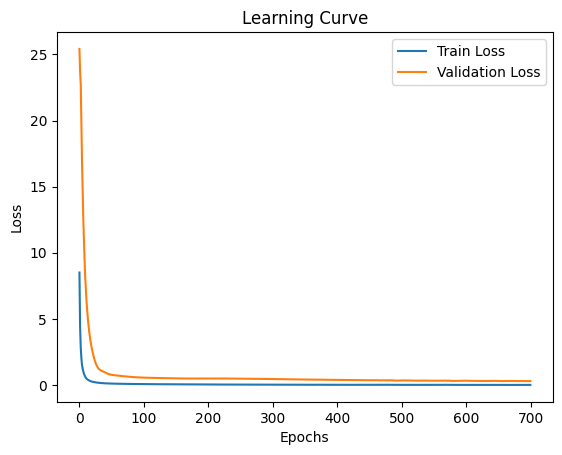

In [152]:
# Graficar la curva de aprendizaje
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [153]:
# Después de finalizar el entrenamiento

# Guardar el modelo en formato .pth
model_path = './models/Multi-classSVDD.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: ./models/Multi-classSVDD.pth


### Clasificación usando Multi Class SVDD

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



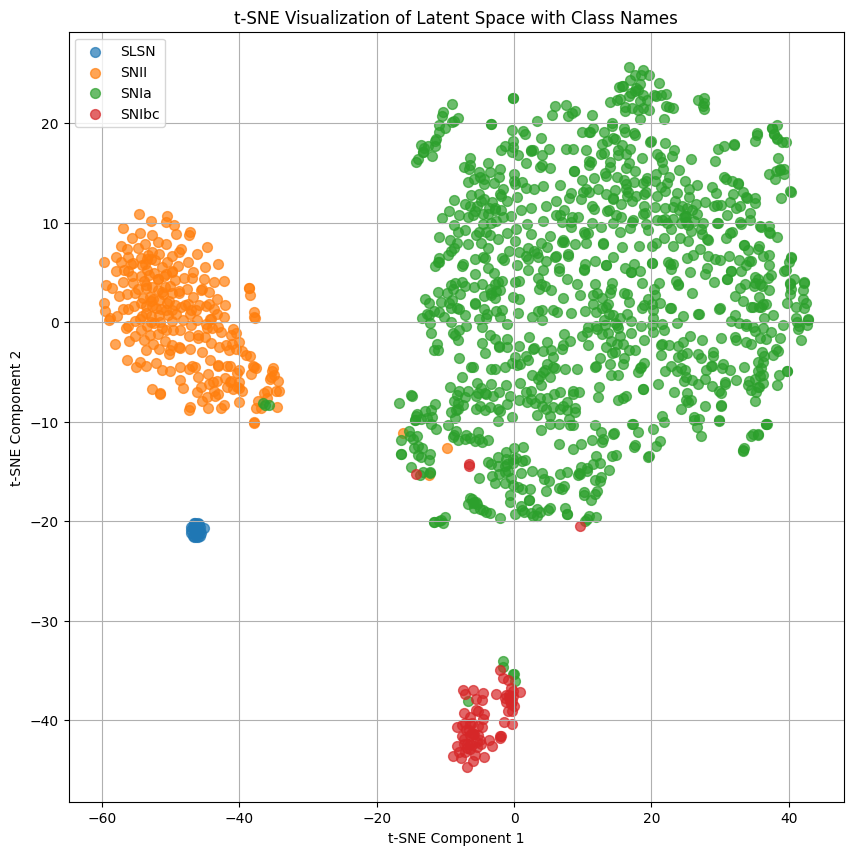

In [154]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Supongamos que tienes las etiquetas originales de entrenamiento
# y_train_transient es un arreglo de las etiquetas categóricas originales

# Crear y ajustar el LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_transient)

# Convertir los datos de entrenamiento a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Obtener los nombres de las clases
class_names = label_encoder.classes_

# Cargar el modelo entrenado
model = MulticlassSVDD(input_dim=input_dim, z_dim=z_dim)
model.load_state_dict(torch.load('./models/Multi-classSVDD.pth'))
model.eval()

# Extraer el espacio latente y las etiquetas
with torch.no_grad():
    latents_train = model.encode(X_train_tensor)
    labels_train = y_train_tensor

# Convertir a numpy
latents_train_np = latents_train.cpu().numpy()
labels_train_np = labels_train.cpu().numpy()

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latents_2d = tsne.fit_transform(latents_train_np)

# Visualizar
plt.figure(figsize=(10, 10))
plt.title('t-SNE Visualization of Latent Space with Class Names')

unique_labels = np.unique(labels_train_np)
for key in unique_labels:
    class_name = class_names[key]
    plt.scatter(latents_2d[labels_train_np == key, 0],
                latents_2d[labels_train_np == key, 1],
                s=50, alpha=0.7, label=class_name)

plt.legend(fontsize=10)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

C:\Users\juans\AppData\Local\Temp\ipykernel_9388\3209757122.py:46: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



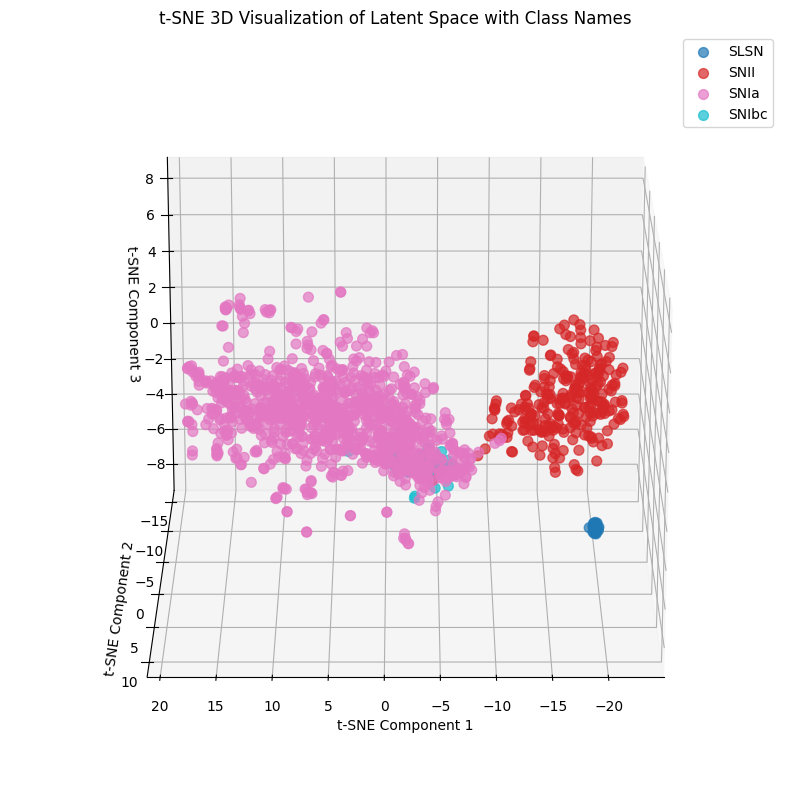

In [155]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

# Supongamos que tienes las etiquetas originales de entrenamiento
# y_train_transient es un arreglo de las etiquetas categóricas originales

# Crear y ajustar el LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_transient)

# Convertir los datos de entrenamiento a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Obtener los nombres de las clases
class_names = label_encoder.classes_

# Cargar el modelo entrenado
model = MulticlassSVDD(input_dim=input_dim, z_dim=z_dim)
model.load_state_dict(torch.load('./models/Multi-classSVDD.pth'))
model.eval()

# Extraer el espacio latente y las etiquetas
with torch.no_grad():
    latents_train = model.encode(X_train_tensor)
    labels_train = y_train_tensor

# Convertir a numpy
latents_train_np = latents_train.cpu().numpy()
labels_train_np = labels_train.cpu().numpy()

# Aplicar t-SNE con n_components=3
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
latents_3d = tsne.fit_transform(latents_train_np)

# Visualización en 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
plt.title('t-SNE 3D Visualization of Latent Space with Class Names')

unique_labels = np.unique(labels_train_np)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for idx, key in enumerate(unique_labels):
    class_name = class_names[key]
    ax.scatter(latents_3d[labels_train_np == key, 0],
               latents_3d[labels_train_np == key, 1],
               latents_3d[labels_train_np == key, 2],
               s=50, alpha=0.7, label=class_name, color=colors(idx))

# Cambiar ángulos de vista
ax.view_init(elev=20, azim=90)  # Cambia los valores según lo desees

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend(fontsize=10, loc='upper right')
plt.show()


In [156]:
import plotly.express as px

In [157]:
# Crear un DataFrame con los resultados de t-SNE y las etiquetas
class_names = LabelEncoder().fit(y_train_transient).classes_
latents_df = pd.DataFrame({
    't-SNE Component 1': latents_3d[:, 0],
    't-SNE Component 2': latents_3d[:, 1],
    't-SNE Component 3': latents_3d[:, 2],
    'Class': [class_names[label] for label in labels_train_np]
})

# Crear la visualización interactiva en 3D con Plotly
fig = px.scatter_3d(
    latents_df,
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    z='t-SNE Component 3',
    color='Class',
    title='t-SNE 3D Interactive Visualization of Latent Space',
    labels={'Class': 'Supernova Class'},
    opacity=0.7
)

# Ajustar el tamaño de los puntos y la altura del gráfico
fig.update_traces(marker=dict(size=3))  # Cambiar tamaño de los puntos (valor más pequeño hace los puntos más pequeños)
fig.update_layout(height=800)  # Cambiar la altura del gráfico (en píxeles)

# Mostrar la figura interactiva
fig.show()

### Detección de outliers según centroide

In [174]:
def detect_outliers(latent_representations, labels, centers, threshold_multiplier=2):
    distances = np.linalg.norm(latent_representations - centers[labels], axis=1)
    thresholds = np.mean(distances) + threshold_multiplier * np.std(distances)
    return np.where(distances > thresholds)[0]

# Cargar el modelo entrenado
model = MulticlassSVDD(input_dim=input_dim, z_dim=z_dim)
model.load_state_dict(torch.load('./models/Multi-classSVDD.pth'))
model.eval()

# Inicializar el centro de las clases usando los datos de entrenamiento
model.set_c(train_loader)

In [175]:
print("Clases codificadas:", class_names)  # Debe mostrar ['SNIa', 'SNII', 'SNIbc', 'SLSN']
unique_labels = torch.unique(y_test_tensor)
print("Etiquetas en los datos de prueba:", unique_labels)
assert len(unique_labels) == 4, "Los datos de prueba no contienen las 4 clases."

Clases codificadas: ['SLSN' 'SNII' 'SNIa' 'SNIbc']
Etiquetas en los datos de prueba: tensor([0, 1, 2, 3])


In [176]:
selected_class_name = "SNIbc"

In [177]:
# Convertir a numpy
latents_train_np = latents_train.cpu().numpy()
labels_train_np = labels_train.cpu().numpy()

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latents_2d = tsne.fit_transform(latents_train_np)

# Obtener los centros de las clases
class_centers = model.c.cpu().numpy()

selected_class = np.where(class_names == selected_class_name)[0][0]
class_indices = np.where(labels_train_np == selected_class)[0]
latents_class = latents_train_np[class_indices]

# Detectar outliers
outliers_indices_class = detect_outliers(latents_class, 
                                         np.zeros_like(class_indices),  # Etiquetas relativas
                                         class_centers[selected_class:selected_class+1])

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



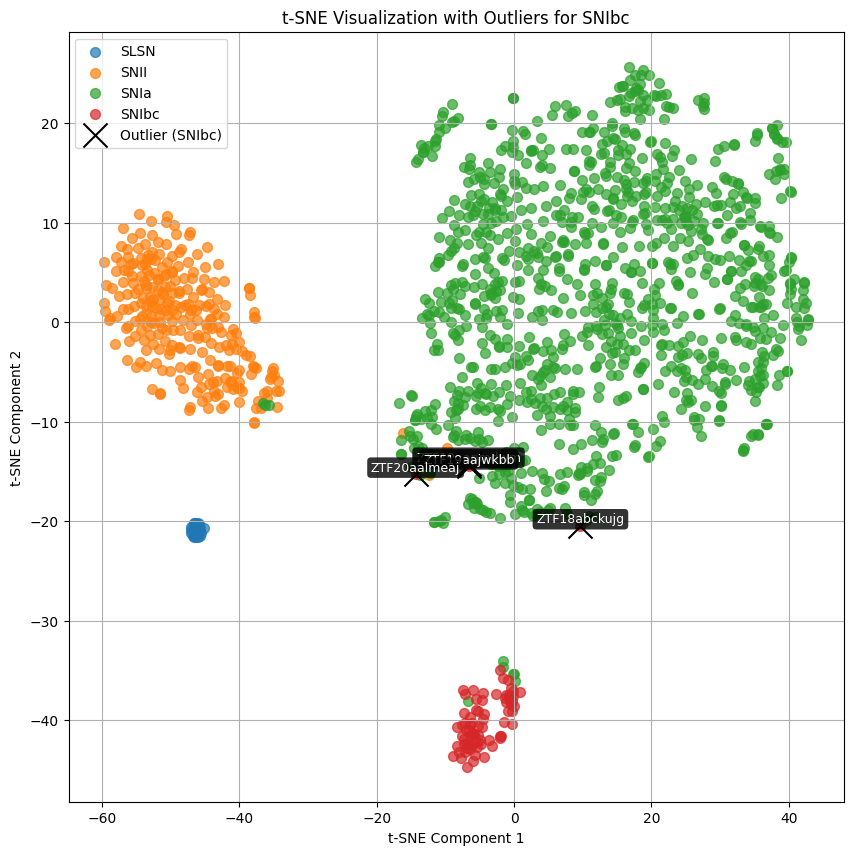

In [185]:
# Visualización
plt.figure(figsize=(10, 10))
plt.title(f't-SNE Visualization with Outliers for {selected_class_name}')

# Dibujar los puntos para cada clase
unique_labels = np.unique(labels_train_np)
for key in unique_labels:
    class_name = class_names[key]
    plt.scatter(
        latents_2d[labels_train_np == key, 0],
        latents_2d[labels_train_np == key, 1],
        s=50, alpha=0.7, label=class_name
    )

# Dibujar los outliers para la clase seleccionada
outlier_latents = latents_2d[class_indices[outliers_indices_class]]
outlier_oids = df_train.iloc[class_indices[outliers_indices_class]]['oid'].values

plt.scatter(
    outlier_latents[:, 0],
    outlier_latents[:, 1],
    s=300, marker='x', color='black', label=f'Outlier ({selected_class_name})'
)

# Agregar el valor de `oid` como tags con fondo negro y texto blanco
for (x, y), oid in zip(outlier_latents, outlier_oids):
    plt.text(
        x, y, str(oid),
        fontsize=9,
        color='white',
        ha='center',
        va='bottom',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='black', alpha=0.8)
    )

# Configuración del gráfico
plt.legend(fontsize=10)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

# Curvas de Luz
Goals:
- Graficar las clasificación SVDD de las clases (listo)
- Detectar los outliers de una clase (cualquiera) usando el centroide de la clase misma
- Plotear los outliers derivados de SVDD usando curvas de luz con el último archivo
- Explicar por qué se confunden los outliers

In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

# Ruta de los archivos en tu Drive
features_file = './data/features_cleaned.csv'
labels_file = './data/dfcrossmatches_prioritized_v7.0.1.csv'

# Cargar el archivo de características con 'oid' como índice
df_feat = pd.read_csv(features_file, index_col='oid')

# Cargar el archivo de etiquetas con 'oid' como índice
df_labels = pd.read_csv(labels_file, index_col='oid', on_bad_lines='skip')


# Verificar si 'classALeRCE' existe en las columnas
if 'classALeRCE' in df_labels.columns:
    # Descartar valores infinitos en df_feat
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

    # Imprimir tamaño de la columna de clases y las primeras filas del DataFrame de características
    print(df_labels['classALeRCE'].values.size)
    print(df_feat.head())
else:
    print("La columna 'classALeRCE' no fue encontrada en df_labels.")
    print("Asegúrate de que el archivo tiene esta columna correctamente definida.")


df_labels['classALeRCE'] = df_labels['classALeRCE'].replace(['SNIIn', 'SNIIb'], 'SNII')

#defining taxonomy tree according to the taxonomy presented in Section 2.2 of the paper.
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

# Definir las columnas que deben ser excluidas de la tabla df_nd
rm_nd_cols = [
    'n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
    'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2',
    'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2',
    'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2',
    'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1',
    'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2'
]

# Verificar qué columnas de rm_nd_cols no están en df_feat
missing_cols = [col for col in rm_nd_cols if col not in df_feat.columns]

if missing_cols:
    print(f"Las siguientes columnas no se encuentran en df_feat y serán ignoradas: {missing_cols}")

# Eliminar solo las columnas que están presentes
cols_to_drop = [col for col in rm_nd_cols if col in df_feat.columns]

# Unir el DataFrame labels con las características restantes, excluyendo las columnas definidas
df = labels.join(df_feat.drop(cols_to_drop, axis=1), how='inner')

# Reemplazar valores infinitos por NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Copiar DataFrame para entrenamiento y rellenar NaN con -999
df_train = df.copy()
df_train = df_train.fillna(-999)

# Extraer las etiquetas
labels = df[['class_original', 'class_hierachical']]

# Verificar si 'Mean_1', 'Mean_2', 'class_original' y 'class_hierachical' están presentes antes de eliminarlas
cols_to_remove = ['Mean_1', 'Mean_2', 'class_original', 'class_hierachical']
cols_to_remove = [col for col in cols_to_remove if col in df.columns]

# Eliminar las columnas existentes
df.drop(cols_to_remove, axis=1, inplace=True)

# Rellenar los NaN restantes con -999
df = df.fillna(-999)

# Mostrar las primeras filas del DataFrame final
list(df.columns)

173879
                  gal_b       gal_l  g-r_max_g_r  g-r_mean_g_r  \
oid                                                              
ZTF18aahvndq  84.778146   32.955580    -0.041541      0.246432   
ZTF19abqviuy -56.280179  109.009059    -0.079274      0.021343   
ZTF19acyogrm -24.613587  148.867482     1.280889      0.400809   
ZTF20aaiovoy  42.559095  209.082699     0.178904      0.587743   
ZTF20abcqpdj  72.178184  147.837430     0.308870      0.400827   

              g-r_max_corr_g_r  g-r_mean_corr_g_r        rb  MHPS_ratio_g  \
oid                                                                         
ZTF18aahvndq               NaN                NaN  0.882857    254.265274   
ZTF19abqviuy               NaN                NaN  0.930000     75.107750   
ZTF19acyogrm          1.227327           0.502450  0.850000      0.314363   
ZTF20aaiovoy               NaN                NaN  0.887143     13.142984   
ZTF20abcqpdj          0.498012           0.541368  0.942857      1.1

['gal_b',
 'gal_l',
 'g-r_max_g_r',
 'g-r_mean_g_r',
 'g-r_max_corr_g_r',
 'g-r_mean_corr_g_r',
 'rb',
 'MHPS_ratio_g',
 'MHPS_low_g',
 'MHPS_high_g',
 'MHPS_non_zero_g',
 'MHPS_PN_flag_g',
 'MHPS_ratio_r',
 'MHPS_low_r',
 'MHPS_high_r',
 'MHPS_non_zero_r',
 'MHPS_PN_flag_r',
 'iqr_g',
 'iqr_r',
 'Amplitude_g',
 'AndersonDarling_g',
 'Autocor_length_g',
 'Beyond1Std_g',
 'Con_g',
 'Eta_e_g',
 'Gskew_g',
 'MaxSlope_g',
 'Mean_g',
 'Meanvariance_g',
 'MedianAbsDev_g',
 'MedianBRP_g',
 'PairSlopeTrend_g',
 'PercentAmplitude_g',
 'Q31_g',
 'Rcs_g',
 'Skew_g',
 'SmallKurtosis_g',
 'Std_g',
 'StetsonK_g',
 'Pvar_g',
 'ExcessVar_g',
 'SF_ML_amplitude_g',
 'SF_ML_gamma_g',
 'IAR_phi_g',
 'LinearTrend_g',
 'Amplitude_r',
 'AndersonDarling_r',
 'Autocor_length_r',
 'Beyond1Std_r',
 'Con_r',
 'Eta_e_r',
 'Gskew_r',
 'MaxSlope_r',
 'Mean_r',
 'Meanvariance_r',
 'MedianAbsDev_r',
 'MedianBRP_r',
 'PairSlopeTrend_r',
 'PercentAmplitude_r',
 'Q31_r',
 'Rcs_r',
 'Skew_r',
 'SmallKurtosis_r',
 'Std_r',

Objetos que son outliers

In [ ]:
# Asegúrate de que `oid` esté disponible como columna
df_train.reset_index(inplace=True)  # `index` se convierte en una columna llamada 'oid'

# Detectar outliers
outliers_indices_class = detect_outliers(
    latents_class,
    np.zeros_like(class_indices),  # Etiquetas relativas
    class_centers[selected_class:selected_class+1]
)

# Obtener los índices originales de los outliers
original_indices_outliers = class_indices[outliers_indices_class]

# Mapear índices originales al `oid`
outliers_oids = df_train.iloc[original_indices_outliers]['oid'].values

# Mostrar los `oid` de los outliers
print(f'OID de los outliers detectados para la clase {selected_class_name}:', outliers_oids)

OID de los outliers detectados para la clase SNIbc: ['ZTF19aapmdwm' 'ZTF19aajwkbb' 'ZTF18abckujg' 'ZTF20aalmeaj']


Objetos que NO son outliers (para comparar)

In [ ]:
# Obtener todos los índices de la clase seleccionada
all_indices_class = set(class_indices)

# Obtener los índices de los outliers
outliers_indices_set = set(original_indices_outliers)

# Calcular los índices que NO son outliers (complemento)
non_outliers_indices = all_indices_class - outliers_indices_set

# Mapear índices originales al `oid`
non_outliers_oids = df_train.iloc[list(non_outliers_indices)]['oid'].values

# Mostrar los `oid` de las muestras que NO son outliers
print(f'OID de las muestras que NO son outliers para la clase {selected_class_name}:', non_outliers_oids)

OID de las muestras que NO son outliers para la clase SNIbc: ['ZTF19aarphwc' 'ZTF20aalkfui' 'ZTF19aariwpf' 'ZTF19aapfktd'
 'ZTF19aaqrime' 'ZTF19acbacvu' 'ZTF19aaxeetj' 'ZTF19aapreza'
 'ZTF19aazlsfj' 'ZTF19aazdcmj' 'ZTF20aamkyyx' 'ZTF18aayivoq'
 'ZTF18abmnrgb' 'ZTF19acrichx' 'ZTF19aamvape' 'ZTF18accwjiu'
 'ZTF18aceynvm' 'ZTF18achaqmd' 'ZTF18acmyxfx' 'ZTF19aaqasrq'
 'ZTF19achetvw' 'ZTF19acfsqjx' 'ZTF19aadgimr' 'ZTF19abcfzdy'
 'ZTF19abgndlf' 'ZTF20aaifyrs' 'ZTF20aaocklb' 'ZTF19achajnc'
 'ZTF19abdkcib' 'ZTF19aatgxjy' 'ZTF20aauowam' 'ZTF19aclkbqc'
 'ZTF19acruqph' 'ZTF18abfhryc' 'ZTF19aazyvub' 'ZTF19abcejrr'
 'ZTF19aamggua' 'ZTF19abpbvsk' 'ZTF19aatmkll' 'ZTF19aceuacu'
 'ZTF19aauivtj' 'ZTF18abncimo' 'ZTF19abpypvc' 'ZTF19aaairqh'
 'ZTF20aafzcab' 'ZTF18acbwarv' 'ZTF18acbwawc' 'ZTF19abdzehg'
 'ZTF18acbzojv' 'ZTF19acygjgx' 'ZTF20aaerqjd' 'ZTF19aanhlxe'
 'ZTF20aayvymx' 'ZTF18acusegd' 'ZTF19abpbbxx' 'ZTF19aaleptm'
 'ZTF19abrcvzz' 'ZTF18acwwowy' 'ZTF18acxyarg' 'ZTF19aayrjnf'
 'ZTF18adbckox' 'ZTF19ab

In [ ]:
import pandas as pd

# Leer el archivo especificando el delimitador y decimales correctamente
detections_SNe_df = pd.read_csv('./data/detections_SNe_v7.0.1.csv')


In [ ]:
# Especificar el objeto a analizar
object_id = 'ZTF19acbunmk'

detections_SNe_df_filter = detections_SNe_df[detections_SNe_df["objectId"]== object_id]

In [ ]:
detections_SNe_df_filter_green = detections_SNe_df_filter[detections_SNe_df_filter["fid"]== 1]
detections_SNe_df_filter_red = detections_SNe_df_filter[detections_SNe_df_filter["fid"]== 2]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


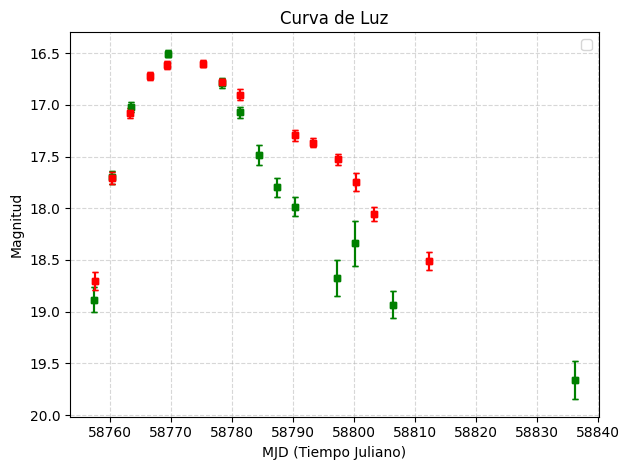

In [ ]:
import matplotlib.pyplot as plt

plt.errorbar(detections_SNe_df_filter_green['mjd'],detections_SNe_df_filter_green['magpsf'],detections_SNe_df_filter_green['sigmapsf'], fmt='s', color='g', capsize=2, markersize=4)
plt.errorbar(detections_SNe_df_filter_red['mjd'],detections_SNe_df_filter_red['magpsf'],detections_SNe_df_filter_red['sigmapsf'], fmt='s', color='r', capsize=2, markersize=4)

plt.gca().invert_yaxis()

# Etiquetas y leyenda
plt.xlabel('MJD (Tiempo Juliano)')
plt.ylabel('Magnitud')
plt.title('Curva de Luz')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()